# DB에서 results를 읽어서 그래프 그리기

<p>won@aimmo.co.kr(swhors@naver.com)</p>

- 주의 사항
  - DB 파일이 잠기면 "sudo fuser -k metrics.db"를 실행하여 주십시요.

In [2]:
!pip install pillow

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


In [1]:
def restart_kernel():
    # Restart the kernet after libraries are loaded.
    import IPython
    from datetime import datetime
    print(f'restart kernel... {datetime.now()}')
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

restart_kernel()

restart kernel... 2025-05-26 11:17:40.837178


In [1]:
import os
import sys
from datetime import datetime
cwd = os.getcwd()
sys.path.append(cwd)
print(sys.path)

print(f'load_library step#1 {datetime.now()}')

['/home/swhors/jupyter-workspace/LSTM/$PWD', '/home/swhors/jupyter-workspace/finance', '/home/swhors/jupyter-workspace/finance/venv/lib/python3.11/site-paches', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/home/swhors/jupyter-workspace/finance/venv/lib/python3.11/site-packages', '/home/swhors/jupyter-workspace/LSTM']
load_library step#1 2025-05-26 11:17:50.511529


In [13]:
from datetime import datetime
from lib.metrics_loader import load_data_by_version
from lib.graph_util import draw_data_graph
from lib.graph_util import draw_data_graph_v2
from lib.graph_util import load_image
from lib.graph_util import draw_graph_with_metric
from lib.graph_util import load_all_image
from lib.db_operate import init_results, conn_db, close_db, drop_table
print(f'load_library step#2 {datetime.now()}')

load_library step#2 2025-05-26 11:21:33.562376


In [14]:
!echo $PYTHONPATH

$PWD:/home/swhors/jupyter-workspace/finance:/home/swhors/jupyter-workspace/finance/venv/lib/python3.11/site-paches


In [26]:
from contextlib import closing


def read_csv(file_name, verbose=False):
    """ read_csv """
    import csv
    results = []
    f = open(file_name, 'r', encoding='utf-8')
    rdf = csv.reader(f)
    cnt = 0
    for line in rdf:
        if cnt == 0:
            columns = line
            if verbose:
                print(f'columns = {columns}')
        else:
            round = int(line[0])
            result = [int(i) for i in line[1:]]
            if verbose:
                print(f'round={round}, result={result}')
            results.append((round, result))
        cnt += 1
    f.close()
    return results


def row_to_result(row):
    """ row_to_result """
    if len(row) != 3:
        return (None, None)
    return row[1], [int(i) for i in row[2].split(",")]


def insert_result(conn, round, result, verbose=False):
    """ insert_result """
    query = "INSERT INTO results (round, metric) values(?, ?)"
    if verbose:
        print(f"query={query}")
        print(f"value={round},{result}")
    with closing(conn.cursor()) as cursor:
        cursor.execute(query, (round, ",".join([str(i) for i in result])))
    conn.commit()


def insert_single(round, result):
    """ insert_single """
    with closing(conn_db('./db/metrics.db')) as conn:
        insert_result(conn=conn, round=round, result=result)
        conn.commit()


def select_result(conn, round=-1, limit=0, is_asc=True, verbose=False):
    """ select_result """
    query = "SELECT * FROM results"
    query = query + ("" if round == -1 else f" where round={round}")
    query = query + ("" if limit == 0 else f" limit {limit}")
    query = query + (" order by round asc" if is_asc else " order by round desc")
    with closing(conn.cursor()) as cursor:
        cursor.execute(query)
        rows = cursor.fetchall()
        results = []
        for row in rows:
            round, result = row_to_result(row)
            if round is not None:
                results.append((round, result))
            if verbose:
                print(f'{type(row)}, {row}')
    return results


def delete_result(conn, round=-1, verbose=False):
    """ delete_result """
    query = "DELETE FROM results"
    query = query + ("" if round == -1 else f" where round={round}")
    with closing(conn.cursor()) as cursor:
        cursor.execute(query)
    conn.commit()


def load_data(verbose=False):
    """ load_data """
    conn = None
    with closing(conn_db('./db/metrics.db')) as conn:
        init_results(conn=conn)
        results_csv = read_csv('selectd3.csv', verbose=False)
        for result in results_csv:
            insert_result(conn, *result, verbose=False)


def get_results(verbose=False):
    """ get_results """
    conn = None
    with closing(conn_db('./db/metrics.db')) as conn:
        results_db = select_result(conn=conn)
        if verbose:
            for result in results_db:
                print(f'result = {result}')
        return results_db


def full_code_test():
    """ full_code_test """
    with closing(conn_db('metrics.db')) as conn:
        init_results(conn=conn)
        results_csv = read_csv('./csv/selectd3.csv', verbose=False)
        for result in results_csv:
            insert_result(conn, *result, verbose=False)
        results_db = select_result(conn=conn)
        for result in results_db:
            print(f'result = {result}')
        delete_result(conn=conn)
        drop_table(conn=conn, table_name="results")


In [27]:
def result_list_mapping(results):
    """ result_list_mapping """
    rounds = []
    result_by_trial = [[],[],[],[],[],[]]
    for result in results:
        pos = 0
        for num in result[1]:
            result_by_trial[pos].append(num)
            pos += 1
        rounds.append(result[0])
    return rounds, result_by_trial


def get_sums_of_metrics(results):
    """ get_sums_of_metrics """
    sums = []
    rounds = []
    for result in results:
        rounds.append(result[0])
        sums.append(sum(result[1]))
    return rounds, sums


In [28]:
# insert single new result
insert_data=False
if insert_data:
    insert_single(round=1172, result=[7, 9, 24, 40, 42, 44])

In [29]:
# load data if wanted

loaded_data = True
print(f'loaded_data step#1 {datetime.now()}')
if loaded_data == False:
    print(f'loaded_data step#2 {datetime.now()}')
    load_data()


loaded_data step#1 2025-05-26 11:25:04.721367


In [30]:
# full code test
want_to_test = False
print(f'full code test step#1 {datetime.now()}')
if want_to_test:
    print(f'full code test step#2 {datetime.now()}')
    code_test()

full code test step#1 2025-05-26 11:25:05.448077


In [32]:
results = get_results()
rounds, result_by_trial = result_list_mapping(results)

from_pos=500, to_pos=573, depth=200


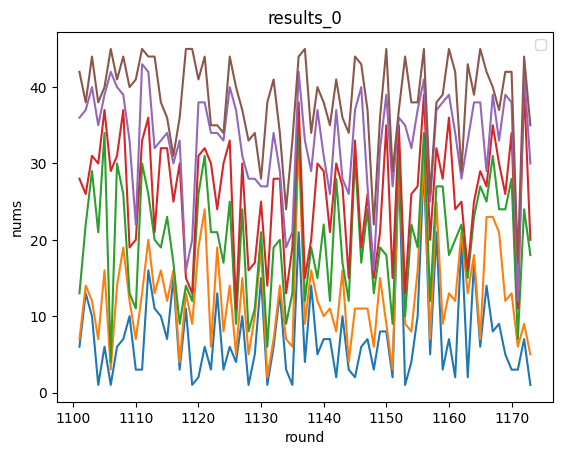

<Figure size 1500x500 with 0 Axes>

In [37]:
from lib.graph_util import draw_data_graph_v2
depth = 200
from_pos = 500
to_pos = len(rounds) if len(rounds) < (from_pos + depth) else (from_pos + depth)
print(f'from_pos={from_pos}, to_pos={to_pos}, depth={depth}')
colors = []
x_data = rounds[from_pos:to_pos]
y_datas = []
for y in result_by_trial:
    y_datas.append(y[from_pos:to_pos])
draw_data_graph_v2(title="results_0",
                   version=999,
                   x_data=x_data,
                   y_datas=y_datas,
                   x_label="round",
                   y_label="nums",
                   colors=colors,
                   height=5,
                   width=15,
                   show_label=False
                  )

from_pos=500, to_pos=573, depth=200


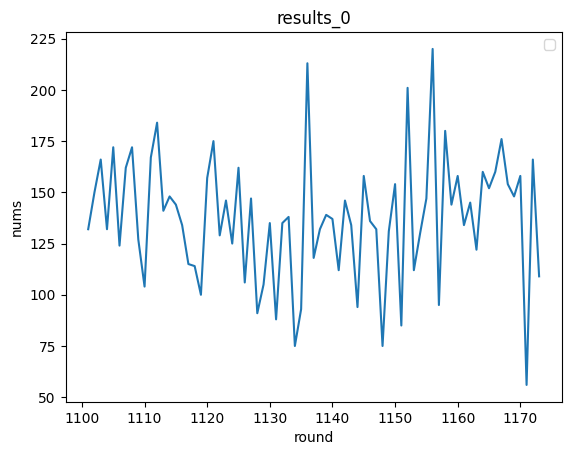

<Figure size 1500x500 with 0 Axes>

In [39]:
rounds, sums = get_sums_of_metrics(results=results)

from lib.graph_util import draw_data_graph_v2
sum_depth = 200
sum_from_pos = 500
sum_to_pos = len(rounds) if len(rounds) < (sum_from_pos + sum_depth) else (sum_from_pos + sum_depth)
print(f'from_pos={sum_from_pos}, to_pos={sum_to_pos}, depth={sum_depth}')

colors = []
x_data = rounds[sum_from_pos:sum_to_pos]
y_datas = [sums[sum_from_pos:sum_to_pos]]
draw_data_graph_v2(title="results_0",
                   version=999,
                   x_data=x_data,
                   y_datas=y_datas,
                   x_label="round",
                   y_label="nums",
                   colors=colors,
                   height=5,
                   width=15,
                   show_label=False
                  )